# Astrophysical $\nu$ Targets

Explore target information from through-going tracks in IceCube.

In [2]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

from astropy.table import Table, unique
from astropy.time import Time

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap, check_hp_target_dir
from desitarget.targetmask import desi_mask, bgs_mask

import healpy as hp

mpl.rc('font', size=14)

## Public Alerts from GCN-AMON

In [3]:
def get_amon_icecube_astrotrack_alerts(url=None):
    """Get IceCube alerts from the GCN AMON channel (IceCube astrotrack).
    This corresponds to single neutrino tracks in the detector between
    roughly 100 TeV and 10 PeV, and includes events from the EHE and HESE
    channels.
    
    Parameters
    ----------
    url : str
        URL of GCN alert webpage.
        
    Returns
    -------
    tab : astropy.table.Table
        Table of alert data.
    """
    if url is None:
        url = 'https://gcn.gsfc.nasa.gov/amon_icecube_gold_bronze_events.html'
        
    # Parse the GCN/AMON notice page.
    html = urlopen('https://gcn.gsfc.nasa.gov/amon_icecube_gold_bronze_events.html')
    soup = BeautifulSoup(html.read())
    events = soup.table.find_all('tr')
    
    # Accumulate event data.
    evtid = []
    run = []
    evt = []
    rev = []
    dtm = []
    noticetype = []
    ra = []
    dec = []
    err90 = []
    err50 = []
    energy = []
    signalness = []
    far = []
    comments = []

    for event in events[2:]:
        data = event.find_all('td')
        _id, _rev, _date, _time, _type, _ra, _dec, _err90, _err50, _energy, _sig, _far, _cmt = [_.string.strip() for _ in data]
        _run, _evt = [int(_) for _ in _id.split('_')]
        evtid.append(_id)
        run.append(_run)
        evt.append(_evt)
        rev.append(int(_rev))

        _dtm = '20{}-{}-{}T{}0'.format(*_date.split('/'), _time)
        dtm.append(_dtm)

        noticetype.append(_type)
        ra.append(float(_ra))
        dec.append(float(_dec))
        err50.append(float(_err50) / 60.)
        err90.append(float(_err90) / 60.)
        energy.append(float(_energy))
        signalness.append(float(_sig))
        far.append(float(_far))
        comments.append(_cmt)
    
    # Push data into an astropy table for later access.
    tab = Table()
    tab['EVENTID'] = evtid
    tab['RUNID'] = run
    tab['EVENT'] = evt
    tab['REVISION'] = rev
    tab['TIME'] = dtm #Time(dtm, format='isot')
    tab['NOTICETYPE'] = noticetype
    tab['RA'] = ra
    tab['RA'].unit = 'degree'
    tab['DEC'] = dec
    tab['DEC'].unit = 'degree'
    tab['ERR50'] = err50
    tab['ERR50'].unit = 'degree'
    tab['ERR90'] = err90
    tab['ERR90'].unit = 'degree'
    tab['ENERGY'] = energy
    tab['ENERGY'].unit = 'TeV'
    tab['SIGNALNESS'] = signalness
    tab['FAR'] = far
    tab['COMMENTS'] = comments
    
    return tab

In [4]:
tab = get_amon_icecube_astrotrack_alerts()
tab

EVENTID,RUNID,EVENT,REVISION,TIME,NOTICETYPE,RA,DEC,ERR50,ERR90,ENERGY,SIGNALNESS,FAR,COMMENTS
,,,,,,deg,deg,deg,deg,TeV,,,
str15,int64,int64,int64,str23,str6,float64,float64,float64,float64,float64,float64,float64,str97
134552_68615710,134552,68615710,1,2020-09-29T17:48:36.830,GOLD,29.5199,3.47,0.4,0.53,182.89,0.47479,1.4109,"IceCube Gold event. The position error is statistical only, there is no systematic added."
134552_68615710,134552,68615710,0,2020-09-29T17:48:36.830,GOLD,29.0479,3.081,0.2,0.5133333333333333,182.89,0.47479,1.4109,"IceCube Gold event. The position error is statistical only, there is no systematic added."
134535_41069485,134535,41069485,1,2020-09-26T22:35:29.220,BRONZE,184.75,32.9299,1.1099999999999999,1.8099999999999998,121.42,0.43381,1.29,"IceCube Bronze event. The position error is statistical only, there is no systematic added."
134535_41069485,134535,41069485,0,2020-09-26T22:35:29.220,BRONZE,188.799,32.069,0.2,0.5133333333333333,121.42,0.43381,1.29,"IceCube Bronze event. The position error is statistical only, there is no systematic added."
134533_53384881,134533,53384881,1,2020-09-26T07:54:11.620,GOLD,96.4599,-4.33,0.38999999999999996,0.66,670.5,0.44137,0.5363,"IceCube Gold event. The position error is statistical only, there is no systematic added."
134533_53384881,134533,53384881,0,2020-09-26T07:54:11.620,GOLD,96.5731,-4.2048,0.2,0.5133333333333333,670.5,0.44137,0.5363,"IceCube Gold event. The position error is statistical only, there is no systematic added."
134512_71996695,134512,71996695,1,2020-09-21T19:07:12.890,BRONZE,195.2899,26.2399,1.07,2.839833333333333,117.17,0.40945,1.5853,"IceCube Bronze event. The position error is statistical only, there is no systematic added."
134512_71996695,134512,71996695,0,2020-09-21T19:07:12.890,BRONZE,195.1971,26.4296,0.2,0.5133333333333333,117.17,0.40945,1.5853,"IceCube Bronze event. The position error is statistical only, there is no systematic added."


## Latest Revisions

Select out the latest reconstructions/revisions of each event.

In [5]:
revtab = unique(tab, keys='EVENTID', keep='first')

### Event Properties

Separate the events in to Bronze and Gold samples and plot properties (angular resolution, FAR, signalness).

In [6]:
ntypes = np.unique(revtab['NOTICETYPE'])
bronze = revtab['NOTICETYPE'] == 'BRONZE'
gold   = revtab['NOTICETYPE'] == 'GOLD'

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


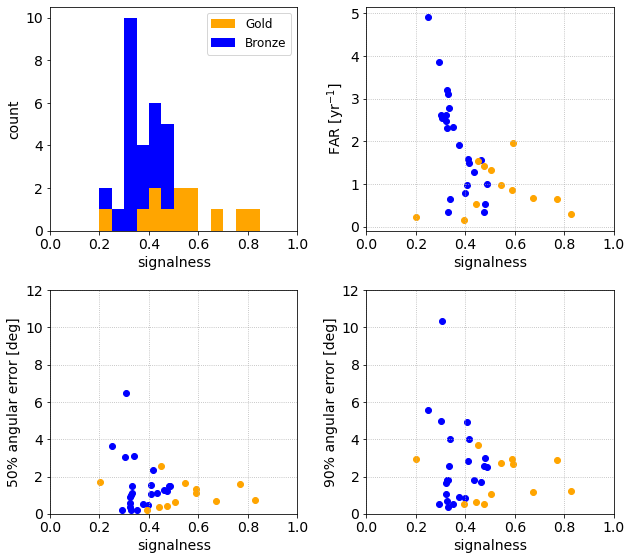

In [7]:
fig, axes = plt.subplots(2,2, figsize=(9,8), tight_layout=True)

sigbr = revtab['SIGNALNESS'][bronze]
siggd = revtab['SIGNALNESS'][gold]
farbr = revtab['FAR'][bronze]
fargd = revtab['FAR'][gold]
err50br = revtab['ERR50'][bronze]
err50gd = revtab['ERR50'][gold]
err90br = revtab['ERR90'][bronze]
err90gd = revtab['ERR90'][gold]

ax = axes[0,0]
sigbins = np.linspace(0,1,21)
ax.hist([siggd, sigbr],
        label=['Gold', 'Bronze'],
        color=['orange', 'blue'],
        bins=sigbins,
        align='mid', stacked=True)
ax.legend(fontsize=12)
ax.set(xlabel='signalness',
       xlim=(0,1),
       ylabel='count');

ax = axes[0,1]
ax.scatter(sigbr, farbr, label='Bronze', color='blue')
ax.scatter(siggd, fargd, label='Gold', color='orange')
ax.set(xlabel='signalness',
       xlim=(0,1),
       ylabel='FAR [yr$^{-1}$]')
ax.grid(ls=':')

ax = axes[1,0]
ax.scatter(sigbr, err50br, label='Bronze', color='blue')
ax.scatter(siggd, err50gd, label='Gold', color='orange')
ax.set(xlabel='signalness',
       xlim=(0,1),
       ylabel='50% angular error [deg]',
       ylim=(0,12))
ax.grid(ls=':')

ax = axes[1,1]
ax.scatter(sigbr, err90br, label='Bronze', color='blue')
ax.scatter(siggd, err90gd, label='Gold', color='orange')
ax.set(xlabel='signalness',
       xlim=(0,1),
       ylabel='90% angular error [deg]',
       ylim=(0,12))
ax.grid(ls=':');

### Event Angular Uncertainties

Plot of events on sky with the DESI footprint.

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 64
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  wa

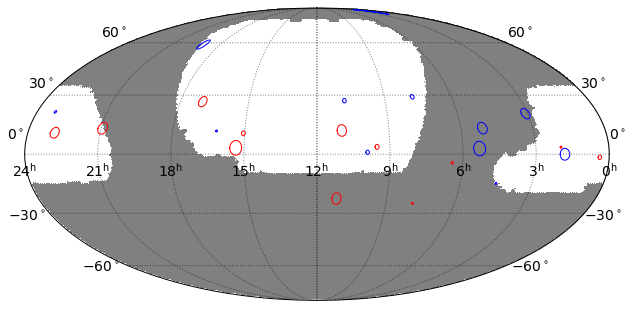

In [8]:
desi_footprint = hp.read_map('../gwtarget/desi_mask_nside0064.fits')
desi_footprint[desi_footprint == 0] = hp.UNSEEN
desi_footprint[desi_footprint == 1] = 0

hp.mollview(desi_footprint, cbar=False, unit=r'probability', title='',
            min=0, max=10, flip='astro', rot=180, cmap='gray_r')
hp.graticule(ls=':', alpha=0.5, dpar=30, dmer=45)

# Draw gold events with 90% containment regions (statistical only).
ra_gold = revtab['RA'][gold]
dec_gold = revtab['DEC'][gold]
err90_gold = revtab['ERR90'][gold]
for _ra, _dec, _err90 in zip(ra_gold, dec_gold, err90_gold):
    cont_ra, cont_dec = [], []
    for phi in np.linspace(0, 2*np.pi, 41):
        cont_ra.append(_ra + _err90*np.cos(phi))
        cont_dec.append(_dec + _err90*np.sin(phi))
    hp.projplot(cont_ra, cont_dec, lonlat=True, lw=1, color='r', label='Gold')

# Draw bronze events with 90% containment regions (statistical only).
ra_brnz = revtab['RA'][bronze]
dec_brnz = revtab['DEC'][bronze]
err90_brnz = revtab['ERR90'][gold]
for _ra, _dec, _err90 in zip(ra_brnz, dec_brnz, err90_brnz):
    cont_ra, cont_dec = [], []
    for phi in np.linspace(0, 2*np.pi, 41):
        cont_ra.append(_ra + _err90*np.cos(phi))
        cont_dec.append(_dec + _err90*np.sin(phi))
    hp.projplot(cont_ra, cont_dec, lonlat=True, lw=1, color='b', label='Bronze')
    
ax = plt.gca()

# Label latitude lines.
ax.text( 2.00,  0.10, r'$0^\circ$', horizontalalignment='left')
ax.text( 1.80,  0.45, r'$30^\circ$', horizontalalignment='left')
ax.text( 1.30,  0.80, r'$60^\circ$', horizontalalignment='left')
ax.text( 1.83, -0.45, r'$-30^\circ$', horizontalalignment='left')
ax.text( 1.33, -0.80, r'$-60^\circ$', horizontalalignment='left')
ax.text(-2.00,  0.10, r'$0^\circ$', horizontalalignment='right')
ax.text(-1.80,  0.45, r'$30^\circ$', horizontalalignment='right')
ax.text(-1.30,  0.80, r'$60^\circ$', horizontalalignment='right')
ax.text(-1.85, -0.45, r'$-30^\circ$', horizontalalignment='right')
ax.text(-1.35, -0.80, r'$-60^\circ$', horizontalalignment='right')

# Label longitude lines.
ax.text( 2.0, -0.15, r'0$^\mathrm{h}$', horizontalalignment='center')
ax.text( 1.5, -0.15, r'3$^\mathrm{h}$', horizontalalignment='center')
ax.text( 1.0, -0.15, r'6$^\mathrm{h}$', horizontalalignment='center')
ax.text( 0.5, -0.15, r'9$^\mathrm{h}$', horizontalalignment='center')
ax.text( 0.0, -0.15, r'12$^\mathrm{h}$', horizontalalignment='center')
ax.text(-0.5, -0.15, r'15$^\mathrm{h}$', horizontalalignment='center')
ax.text(-1.0, -0.15, r'18$^\mathrm{h}$', horizontalalignment='center')
ax.text(-1.5, -0.15, r'21$^\mathrm{h}$', horizontalalignment='center')
ax.text(-2.0, -0.15, r'24$^\mathrm{h}$', horizontalalignment='center');

### Gold Events with Highest Signalness and Lowest Angular Uncertainty

In [9]:
select = (revtab['SIGNALNESS'] > 0.6) & (revtab['ERR90'] < 3)
revtab[select]

EVENTID,RUNID,EVENT,REVISION,TIME,NOTICETYPE,RA,DEC,ERR50,ERR90,ENERGY,SIGNALNESS,FAR,COMMENTS
,,,,,,deg,deg,deg,deg,TeV,,,
str15,int64,int64,int64,str23,str6,float64,float64,float64,float64,float64,float64,float64,str97
132910_57145925,132910,57145925,1,2019-07-30T20:50:41.310,GOLD,225.7899,10.47,0.6623333333333333,1.1849999999999998,298.81,0.67158,0.677,"IceCube Gold event. The position error is statistical only, there is no systematic added."
133609_37927131,133609,37927131,1,2020-01-09T23:41:39.930,GOLD,164.49,11.8699,1.6099999999999999,2.9099999999999997,375.23,0.76931,0.6409,"IceCube Gold event. The position error is statistical only, there is no systematic added."
134191_17593623,134191,17593623,1,2020-06-15T14:49:17.370,GOLD,142.9499,3.66,0.7198333333333333,1.2198333333333333,496.36,0.82832,0.2894,"IceCube Gold event. The position error is statistical only, there is no systematic added."


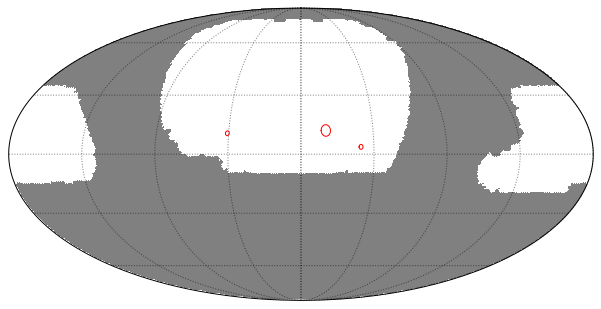

In [10]:
hp.mollview(desi_footprint, cbar=False, unit=r'probability', title='',
            min=0, max=10, flip='astro', rot=180, cmap='gray_r')
hp.graticule(ls=':', alpha=0.5, dpar=30, dmer=45)

# Draw gold events with 90% containment regions (statistical only).
ra_gold = revtab['RA'][select]
dec_gold = revtab['DEC'][select]
err90_gold = revtab['ERR90'][select]
for _ra, _dec, _err90 in zip(ra_gold, dec_gold, err90_gold):
    cont_ra, cont_dec = [], []
    for phi in np.linspace(0, 2*np.pi, 41):
        cont_ra.append(_ra + _err90*np.cos(phi))
        cont_dec.append(_dec + _err90*np.sin(phi))
    hp.projplot(cont_ra, cont_dec, lonlat=True, lw=1, color='r', label='Gold')

## Load DRx Targets

In [11]:
nside = 1024

event = revtab[revtab['EVENTID']=='134191_17593623']
run_c = event['RUNID'][0]
evt_c = event['EVENT'][0]
ra_c = event['RA'][0]
dec_c = event['DEC'][0]
vec_c = hp.ang2vec(ra_c, dec_c, lonlat=True)
err50_c = event['ERR50'].to('radian').value[0]
err90_c = event['ERR90'].to('radian').value[0]

pix90 = hp.query_disc(nside, vec=vec_c, radius=err90_c, nest=True)

In [12]:
# Load sample of resolved DR8 target catalog using HEALPixels in the 90% C.I.
hpdirname = '/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/dark'
targ90 = Table(read_targets_in_hp(hpdirname, nside=nside, pixlist=pix90))

In [13]:
ra_c, dec_c, err50_c, err90_c

(142.9499, 3.66, 0.012563461732272515, 0.021290107992244164)

In [14]:
targ90

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_EPOCH,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL
int16,int32,str8,int32,str4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,int8,float32,float32,float32,float32,float32,float32,str1,int64,int64,int64,int64,float64,int64,int64,int64,int64
8000,348215,1418p030,619,REX,141.97114649067464,15985453000.0,2.910033362885676,15861059000.0,808.1 .. 0.0,0.044643782,0.46313787,0.68887866,1.1100796,1753.8335,639.26404,120.191574,0.87620544,0.914826,0.95142496,0.0029178022,0.0013657187,0.0044246106,0.01943813,0.011899038,0.017050136,0.99391633,0.9955799,0.99444944,5,4,4,2120.5435,828.6696,152.10352,1436.091,475.81622,82.69751,2.1217358,-0.9863916,-3.6436799,-208.06448,2.5600247,0.49838182,0.00065288256,8.220103e-06,0.99246275,0.99536437,0.99900955,0.9996259,0,0,0,0.32077423,0.47712472,0.768853,0.32077423,0.47712472,0.768853,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.23710144,0.0,0.0,821.9551,0.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,S,35185832608399979,131074,0,0,0.2246526889465944,3,3000,1,27319
8000,348215,1418p030,664,DEV,141.98084379789395,963148700000.0,2.9121649165806303,1821259600000.0,69765.625 .. 80366.95,0.044765867,2.1424043,11.818817,28.46972,939.47504,236.76802,52.844666,0.8758888,0.9146033,0.95129544,0.002485359,0.0004987613,0.00049972534,0.012475404,0.011394713,0.012441265,0.99826217,0.9985938,0.99764436,5,4,4,2120.5435,828.6696,152.10352,1436.091,475.81622,82.69751,52.427814,33.553234,2.447871,-301.55133,2.1972544,0.44843066,0.0006012674,8.333295e-06,0.99244225,0.99535173,0.9990068,0.99962485,0,0,0,0.97330606,5.3693533,12.93395,0.97330606,5.3693533,12.93395,0.0,0,0,0,1.0,1.0,0.83796054,-0.5086174,0.1369798,18845.357,14432.479,11633.069,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,S,35185832608400024,1152921504606846976,65537,0,0.7960246254263872,7,2000,1,27319
8000,348215,1418p030,665,EXP,141.97996727949206,886005240000.0,2.9099974404195326,498788960000.0,53634.73 .. 67124.85,0.04481546,2.2598586,11.585405,26.50207,895.34534,221.85033,46.005646,0

In [15]:
ra90, dec90 = [targ90[_] for _ in ['RA', 'DEC']]

len(targ90)

18361

### Plot Selected Targets within 90% C.I.

In [16]:
xmin = np.round(ra_c - 2)
xmax = np.round(ra_c + 2)
# xmin = angle_to_180(np.round(ra_c - 5))
# xmax = angle_to_180(np.round(ra_c + 5))
if xmax < xmin:
    xmin, xmax = xmax, xmin
cxmin, cxmax = xmin, xmax
frot = 0.
if xmax > 90 and xmin < -90:
    frot, cxmin, cmax = 180., xmax-180., xmax+180.
ymin = np.round(dec_c - 2)
ymax = np.round(dec_c + 2)

faspect = np.abs(cxmax - cxmin)/np.abs(ymax-ymin)
fysize = 4
figsize = (fysize*faspect+2, fysize+2.75)
figsize

(6.0, 6.75)

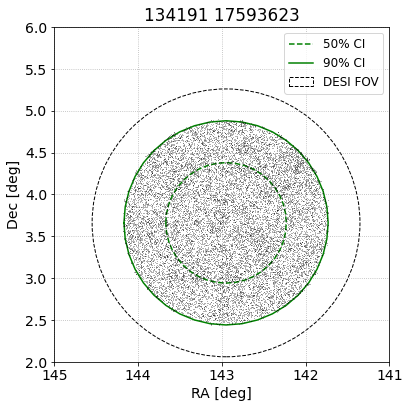

In [17]:
fig, ax = plt.subplots(1,1, num=1, figsize=figsize)

for _radius, _lstyle, _clev in zip([err50_c, err90_c], ['--', '-'], ['50', '90']):
    cont_ra, cont_dec = [], []
    _r = np.degrees(_radius)
    for phi in np.linspace(0, 2*np.pi, 41):
        cont_ra.append(ra_c + _r*np.cos(phi))
        cont_dec.append(dec_c + _r*np.sin(phi))
    ax.plot(cont_ra, cont_dec, 'g', ls=_lstyle, label='{}% CI'.format(_clev))

ratarg, dectarg = ra90, dec90
ratarg[ratarg < 0] += 360

ax.plot(ratarg, dectarg, 'k,', alpha=0.3)
ax.set(xlim=(cxmax, cxmin),
       xlabel='RA [deg]',
       ylabel='Dec [deg]',
       ylim=(ymin, ymax),
       title='{} {}'.format(run_c, evt_c),
       aspect='equal')
ax.grid(ls=':')

circ = plt.Circle((ra_c, dec_c), radius=1.6, fc='None', ec='k', ls='--')
ax.add_artist(circ)

_h, _l = ax.get_legend_handles_labels()
_h.append(circ)
_l.append('DESI FOV')

ax.legend(handles=_h, labels=_l, fontsize=12)

# # cb = fig.colorbar(img, orientation='horizontal', shrink=0.85, fraction=0.1,
# #                   pad=0.1, ax=ax)
# # cb.set_label(r'GW angular posterior Pr$(\alpha,\delta)$')
fig.savefig('targlist.png')